In [1]:
import read_data as rd
import pandas as pd
import numpy as np
import csv
import sklearn
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import visualizations as viz
import matplotlib.cm as cm
import itertools
%matplotlib inline

## Data Prep

In [2]:
clean_df = rd.read_data(read_drek=True, read_holiday=False, read_weather_station=False,
                        read_water_sensor=False, read_daily_forecast=False, read_hourly_forecast=False,
                        group_beaches=False
                       )

In [3]:
drek_df = clean_df[['Drek_Prediction', 'Escherichia.coli']].copy().dropna()

In [73]:
df = clean_df.copy()
df.drop(['Reading.1', 'Reading.2', 'Units', 'Sample.Collection.Time', 
         'Date', 'Laboratory.ID', 'Weekday', 'Beach', 'Year',
         'Drek_Reading', 'Drek_Prediction', 'Drek_Worst_Swim_Status'], axis=1, inplace=True)
df = df[~df['Escherichia.coli'].isnull()]
df.rename(columns={'Full_date': 'Date', 'Client.ID': 'Beach'}, inplace=True)

cleannames_file = '../data/ChicagoParkDistrict/raw/Standard 18 hr Testing/cleanbeachnames.csv'
with open(cleannames_file) as f:
    next(f)
    cleannames_dict = {line[1]: line[3] for line in csv.reader(f)}
    
df.Beach.replace(cleannames_dict, inplace=True)

df = df[~df.duplicated(subset=['Date', 'Beach'])]

#we're just looking at years 2006-2014 for now
df = df[df.Date.dt.year < 2015]

### Getting values for previous day's e.coli levels

In [5]:
def get_prev_day(df, target, n=1):
    if isinstance(target, str):
        prev_target = str(n)+ '_prev_' + target
    else:
        prev_target = [str(n)+ '_prev_' + key for key in target]
        
    df = df.sort_values(by='Date').reset_index(drop=True)
    df[prev_target] = df.groupby(['Beach', df.Date.dt.year]).shift()[target]

    return df

def get_prev_ecoli(df, option, n):
    """
    Fills in e.coli reading values for previous day, depending on selected logic.
    
    Inputs
    -------
    df: pandas dataframe, with Date, Beach, and Escherichia.coli columns
    option: 1, 2, or 3 (numeric)
        1: just use the previous entry, regardless of whether it's the actual previous day
        2: use the average for that particular week (Sun-Sat) to fill in NA values
        3: use the average of the 5 previous days to fill in NAs.
    
    Returns
    -------
    df: modified dataframe with prev_Ecoli column
    """
    if option == 1: 
        return get_prev_day(df, 'Escherichia.coli', n)
    
    else:
        prev_df = pd.concat([df[df.Date.dt.year == year].groupby('Beach')\
                             .apply(lambda x: x.set_index('Date').resample('D').asfreq())\
                             .drop('Beach', axis=1).reset_index()
                            for year in range(2006, 2015)])
        prev_df = get_prev_day(prev_df, 'Escherichia.coli', n).drop(['Escherichia.coli'], axis=1)
        prev_name = str(n) + '_prev_Escherichia.coli'
        if option == 2:
            
            prev_df[prev_name] = prev_df.groupby(['Beach', prev_df.Date.dt.year, 
                                                                prev_df.Date.dt.week])[prev_name]\
                                                      .transform(lambda x: x.fillna(x.mean()))
        else:
            prev_df['mean'] = prev_df.groupby(['Beach', prev_df.Date.dt.year])[prev_name]\
                                     .apply(lambda x: x.rolling(min_periods=1, center=False, window=5).mean())
            prev_df.loc[prev_df[prev_name].isnull(), 
                        prev_name] = prev_df['mean']
            prev_df.drop(['mean'], axis=1, inplace=True)
        
        #any remaining nulls are replaced with average across all years excluding that year 
        for year in range(2006, 2015):
            mean = df[df.Date.dt.year != year]['Escherichia.coli'].mean()
            prev_df.loc[prev_df[prev_name].isnull(), 
                        prev_name] = mean
            
        return pd.merge(df, prev_df, on=['Date', 'Beach'], how='left')
            

In [125]:
def get_prev_nday(df, target, n=1, mean_window=7):
    min_yr = df.Date.dt.year.min()
    max_yr = df.Date.dt.year.max()
    yr_range = range(min_yr, max_yr+1)
    
    prev_df = pd.concat([df[df.Date.dt.year == year].groupby('Beach')\
                         .apply(lambda x: x.set_index('Date').resample('D').asfreq())\
                         .drop('Beach', axis=1).reset_index()
                         for year in yr_range])
    
    if isinstance(target, str):
        target = [target, ]
    
    prev_target = [str(n)+ '_prev_' + key for key in target]
    prev_df[prev_target] = prev_df.groupby(['Beach', prev_df.Date.dt.year]).shift()[target]
    prev_df.drop(target, axis=1, inplace=True)
    
    means = prev_df.groupby(['Beach', prev_df.Date.dt.year])[prev_target]\
                   .transform(lambda x: x.rolling(min_periods=1, center=False, window=mean_window).mean())
    
    prev_df[prev_target] = prev_df[prev_target].fillna(means)
    
    for yr in yr_range:
        means = prev_df[prev_df.Date.dt.year != yr].mean()
        prev_df.loc[prev_df.Date.dt.year == yr, prev_target] =\
        prev_df.loc[prev_df.Date.dt.year == yr, prev_target].fillna(means)
        
    
    return prev_df  

### Adding in lat & lon for each beach

In [5]:
beach_locs = pd.read_csv('../data/ExternalData/Beach_Locations.csv')
beach_locs.Beach.replace(cleannames_dict, inplace=True)
beach_locs = beach_locs.groupby('Beach').mean().reset_index()

### Forecast.io data

Daily forecast data

In [127]:
forecast = pd.read_csv('../data/ExternalData/forecastio_daily_weather.csv')
forecast.time = pd.to_datetime(forecast.time)
forecast.rename(columns={'time': 'Date', 'beach': 'Beach'}, inplace=True)
forecast.Beach.replace(cleannames_dict, inplace=True)
forecast = forecast[~forecast.duplicated(subset=['Date', 'Beach'])]

Hourly forecast data

In [7]:
hr_forecast = pd.read_csv('../data/ExternalData/forecastio_hourly_weather.csv')
hr_forecast.time = pd.to_datetime(hr_forecast.time)
hr_forecast.rename(columns={'time': 'Date', 'beach': 'Beach'}, inplace=True)
hr_forecast.Beach.replace(cleannames_dict, inplace=True)
hr_forecast = hr_forecast[~hr_forecast.duplicated(subset=['Date', 'Beach'])]

### Misc other feature engineering

In [9]:
df['week'] = df.Date.dt.week
df['weekday'] = df.Date.dt.weekday

In [ ]:
navy_pier = 41.8916
df['n_pier'] = df.Latitude > navy_pier

In [ ]:
#these bins are based on the forecast.io docs on rain intensity 
bins = [-float('inf'), 1e-12, 0.002, 0.017, 0.1, 0.4, float('inf')]
labels = list(range(len(bins)-1))
for col in ['prev_precipIntensity', 'prev_precipIntensityMax', 'hr4_precipIntensity']:
    df[col + '_cat'] = pd.cut(df[col], bins=bins, labels=labels).tolist()


## Models

In [10]:
def run_model(df, model, predictors, target='Escherichia.coli', threshold=235, yrs=range(2006,2015), 
             leave_out_06=True, leave_out_07=True):
    
    full_model_df = df[['Date', target] + predictors].copy().dropna()
    
    for predictor in predictors:
        if full_model_df[predictor].dtype == 'object':
            full_model_df[predictor] = pd.Categorical(full_model_df[predictor]).codes
    
    if leave_out_06 and leave_out_07:
        model_df = full_model_df[(full_model_df.Date.dt.year != 2006) &
                                 (full_model_df.Date.dt.year != 2007)]
    elif leave_out_06:
        model_df = full_model_df[full_model_df.Date.dt.year != 2006]
    elif leave_out_07:
        model_df = full_model_df[full_model_df.Date.dt.year != 2006]
    else:
        model_df = full_model_df

    
    fits = {}
    for yr in yrs:
        model = sklearn.base.clone(model) 
        train = model_df[model_df.Date.dt.year != yr][predictors]
        classes = model_df[model_df.Date.dt.year != yr][target] > threshold
        
        fits[yr] = model.fit(train, classes)
        
    return fits, full_model_df
        
def calc_metrics(model_df, predictors, fits, metrics=[], 
                 target='Escherichia.coli', threshold=235, gen_avg=False):
    
    calced_metrics = {}
    avg_calced_metrics = {}
    for metric in metrics:
        yr_scores = {}
        
        for yr, fit in fits.items():
            test = model_df[model_df.Date.dt.year == yr][predictors]
            true_classes = model_df[model_df.Date.dt.year == yr][target] > threshold
            
            if 'roc' in metric:
                preds = fit.predict_proba(test)[:,1]
            else:
                preds = fit.predict(test)
        
            yr_scores[yr] = getattr(sklearn.metrics, metric)(true_classes, preds)
        
        calced_metrics[metric] = yr_scores
        if gen_avg:
            try:
                avg_calced_metrics[metric] = np.array(list(calced_metrics[metric].values()))\
                                               .mean(axis=0)
            except ValueError: 
                print("Can't average %s" %metric)
                
    return (calced_metrics, avg_calced_metrics) if gen_avg else calced_metrics

def plot_roc(roc_dict, drek_df, roc_aucs=None):
    colors = itertools.cycle(sns.color_palette('colorblind', 6))
    
    for yr, arrays in metrics['roc_curve'].items():
        if roc_aucs is not None:
            label = str(yr) + " - AUC: {:0.4f}".format(roc_aucs[yr])
        else:
            label = yr
        fpr = arrays[0]
        tpr = arrays[1]
        if yr <= 2010:
            plt.plot(fpr, tpr, label=label, color=next(colors))
        else:
            plt.plot(fpr, tpr, '--', label=label, color=next(colors))
    
    plt.plot([0, 1], [0, 1], 'r:')
    fpr, tpr, _ = sklearn.metrics.roc_curve(drek_df['Escherichia.coli'] > 235, 
                                            drek_df['Drek_Prediction'])
    
    if roc_aucs is not None:
        drek_auc = sklearn.metrics.roc_auc_score(drek_df['Escherichia.coli'] > 235, 
                                                 drek_df['Drek_Prediction'])
        label = 'Drek - AUC: {:0.4f}'.format(drek_auc)
    else:
        label = 'Drek'
        
    plt.plot(fpr, tpr, 'k--', lw=2, label=label)

    plt.legend(loc='lower right', fontsize=12)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.show()

def get_feat_df(fits, predictors):
    vals = [[yr, feat, imp] for yr, fit in fits.items() 
            for feat, imp in zip(predictors, fit.feature_importances_)] 
    
    return pd.DataFrame(vals, columns = ['Year', 'Feature', 'Importance'])

### GBM

In [ ]:
gbm_df = df.copy()

### We want to previous day's forecast values
# reordering forecast columns to make my life easier
col_list = ['Date', 'Beach']+[col for col in forecast.columns 
                                  if col != 'Date' and col != 'Beach']
gbm_forecast = forecast.copy()[col_list]
gbm_forecast = get_prev_day(gbm_forecast, gbm_forecast.columns.tolist()[2:])

cols = ['Date', 'Beach'] + [col for col in gbm_forecast.columns if 'prev' in col]
gbm_df = pd.merge(gbm_df, gbm_forecast[cols], on=['Beach', 'Date'])

### Just looking at the 4am time point
time = 4
col_list = ['Date', 'Beach']+[col for col in hr_forecast.columns 
                              if col != 'Date' and col != 'Beach']
subhr_df = hr_forecast.copy()[hr_forecast.Date.dt.hour == time]\
                             [col_list].reset_index(drop=True)
prefix = 'hr' + str(time) + '_'
subhr_df.columns = col_list[:2] + [prefix + col 
                                   for col in col_list[2:]]
subhr_df.drop(prefix + 'precipType', axis=1, inplace=True)
subhr_df.Date = pd.DatetimeIndex(subhr_df.Date).normalize()

gbm_df = pd.merge(gbm_df, subhr_df, on=['Beach', 'Date'])

In [ ]:
gbm_df.columns.tolist()

In [ ]:
ignore = ['Date','Beach','Escherichia.coli', '1_prev_summary', '1_prev_precipType', 
          '1_prev_precipIntensityMaxTime', 'hr5_summary', 'hr5_precipType'
         ]
predictors = [col for col in gbm_df.columns if col not in ignore]
model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.05,
                                   max_depth=4, subsample=0.7, verbose=False)
fits, model = run_model(gbm_df, model, predictors)

In [ ]:
metrics, avg_metrics = calc_metrics(model, predictors, fits, 
                                    metrics=['roc_curve', 'recall_score', 'roc_auc_score'], 
                                    gen_avg=True)

plt.figure(figsize=(8,8))
plot_roc(metrics['roc_curve'], drek_df)

**Curious if any particular hour (0-6am) is best, or if a mean is best**

In [ ]:
col_list = ['Date', 'Beach']+[col for col in hr_forecast.columns 
                              if col != 'Date' and col != 'Beach']
hr_forecast = hr_forecast[col_list]
df_list = []
for time in range(7):
    subhr_df = hr_forecast[hr_forecast.Date.dt.hour == time]\
                          [col_list].reset_index(drop=True)
    prefix = 'hr' + str(time) + '_'
    subhr_df.columns = col_list[:2] + [prefix + col 
                                       for col in col_list[2:]]
    subhr_df.drop(prefix + 'precipType', axis=1, inplace=True)
    subhr_df.Date = pd.DatetimeIndex(subhr_df.Date).normalize()
    subhr_df[prefix + 'summary'] = pd.Categorical(subhr_df[prefix + 'summary']).codes
    subhr_df[prefix + 'icon'] = pd.Categorical(subhr_df[prefix + 'icon']).codes
    
    df_list.append(subhr_df)

In [ ]:
multi_hr = df_list[0]
for hr_df in df_list[1:]:
    multi_hr = pd.merge(multi_hr, hr_df, on=['Date', 'Beach'])

In [ ]:
for col in col_list[4:-1]: 
    hr_cols = ['hr' + str(time) + '_' + col for time in range(7)]
    multi_hr['mean_' + col] = multi_hr[hr_cols].mean(axis=1)

In [ ]:
#multi_hr.columns.tolist()

In [ ]:
morning_df = pd.merge(df, multi_hr, on=['Beach', 'Date'])
morning_df = pd.merge(morning_df, beach_locs, on='Beach')

In [ ]:
#ignore = ['Date', 'Escherichia.coli', 'Year', 'Longitude']
#predictors = [col for col in morning_df.columns if col not in ignore]
predictors = ['Latitude', 'hr5_windSpeed', 'hr5_windBearing', 'hr5_cloudCover',
              'hr5_humidity', 'hr5_dewPoint', 'hr5_apparentTemperature', 'hr5_pressure']
model = GradientBoostingClassifier(n_estimators=200, learning_rate=0.05,
                                   max_depth=4, subsample=0.7)
fits, model = run_model(morning_df, model, predictors)

In [ ]:
feat_df = get_feat_df(fits, predictors)
pd.options.display.max_rows = 999
#feat_df.sort_values(by=['Year', 'Importance'], ascending=[True, False]).groupby('Year').head(15)

In [ ]:
metrics, avg_metrics = calc_metrics(model, predictors, fits, 
                                    metrics=['roc_curve', 'recall_score', 'roc_auc_score'], 
                                    gen_avg=True)

plt.figure(figsize=(8,8))
plot_roc(metrics['roc_curve'], drek_df)

**Reproducing Kevin's stuff**

In [10]:
#Add columns for 1 through 7 previous day ecoli readings
huge_df = df.copy()

prev_days = [get_prev_ecoli(df, 3, i).drop('Escherichia.coli', axis=1) for i in range(1, 8)]
for prev_df in prev_days:
    huge_df = pd.merge(huge_df, prev_df, on=['Date', 'Beach'])

#Get historical average across those 7 days
prev_cols = [col for col in huge_df.columns if 'prev' in col]
huge_df['historical_average_Escherichia.coli'] = huge_df[prev_cols].mean(axis=1)

In [12]:
#Add in historical averages for daily forecast of temperatureMin and temperatureMax
kforecast = forecast.copy()
kforecast = kforecast.sort_values(by=['Beach', 'Date'])
kforecast['historical_average_temperatureMin'] =\
         kforecast.groupby(['Beach', forecast.Date.dt.year])['temperatureMin']\
                  .apply(lambda x: x.rolling(min_periods=1, center=False, window=3).mean())
        
kforecast['historical_average_temperatureMax'] =\
         kforecast.groupby(['Beach', forecast.Date.dt.year])['temperatureMax']\
                  .apply(lambda x: x.rolling(min_periods=1, center=False, window=3).mean())

In [13]:
hr_forecast = pd.read_csv('../data/ExternalData/forecastio_hourly_weather.csv')
hr_forecast.time = pd.to_datetime(hr_forecast.time)
hr_forecast.rename(columns={'time': 'Date', 'beach': 'Beach'}, inplace=True)
hr_forecast.Beach.replace(cleannames_dict, inplace=True)
hr_forecast = hr_forecast[~hr_forecast.duplicated(subset=['Date', 'Beach'])]

In [14]:
#Separate hourly data into multiple columns, add previous day columns as well
col_list = ['Date', 'Beach']+[col for col in hr_forecast.columns 
                              if col != 'Date' and col != 'Beach' and col != 'precipType']
hr_forecast = hr_forecast[col_list]
hr_forecast = hr_forecast.sort_values(by='Date').reset_index(drop=True)
hr_forecast = hr_forecast.groupby('Beach').apply(pd.Series.interpolate)

df_list = []
for time in range(24):
    subhr_df = hr_forecast[hr_forecast.Date.dt.hour == time]\
                          [col_list].reset_index(drop=True)
    prefix = 'hr' + str(time) + '_'
    subhr_df.columns = col_list[:2] + [prefix + col 
                                       for col in col_list[2:]]
    subhr_df.Date = pd.DatetimeIndex(subhr_df.Date).normalize()
    subhr_df[prefix + 'summary'] = pd.Categorical(subhr_df[prefix + 'summary']).codes
    subhr_df[prefix + 'icon'] = pd.Categorical(subhr_df[prefix + 'icon']).codes
    
    df_list.append(subhr_df)
    
multi_hr = df_list[0]
for hr_df in df_list[1:]:
    multi_hr = pd.merge(multi_hr, hr_df, on=['Date', 'Beach'])
    
target = multi_hr.columns.tolist()[2:]
multi_hr = get_prev_day(multi_hr, target, 1).sort_values(by=['Date'])

In [ ]:
#put it all together
huge_df = pd.merge(huge_df, multi_hr, on=['Beach', 'Date'])
huge_df = pd.merge(huge_df, kforecast, on=['Beach', 'Date'])
huge_df = pd.merge(huge_df, beach_locs, on=['Beach'])


In [19]:
#add column for n-s of navy pier
navy_pier = 41.8916
huge_df['n_pier'] = huge_df.Latitude > navy_pier

In [ ]:
predictors = ["%s_prev_Escherichia.coli" %i for i in range(1,8)] +\
             []

In [22]:
predictors = ['1_prev_hr13_temperature', 'precipIntensityMax', '1_prev_hr8_temperature',
              'hr1_windBearing', 'cloudCover', '1_prev_hr11_temperature', 'windSpeed', 
              'hr3_windBearing', 'hr2_windBearing', 'hr2_cloudCover', '1_prev_hr15_temperature',
              'humidity', 'hr4_windBearing', 'hr3_windSpeed', '1_prev_hr21_temperature', 'hr4_cloudCover',
              'hr4_windSpeed', '1_prev_hr12_temperature', 'hr0_temperature', 'hr0_pressure', 'precipIntensity', 
              'hr2_windSpeed', 'sunriseTime', 'temperatureMin', 'hr1_windSpeed', 'hr0_cloudCover', 
              '1_prev_Escherichia.coli', '2_prev_Escherichia.coli', '3_prev_Escherichia.coli',
              '4_prev_Escherichia.coli', '5_prev_Escherichia.coli', '6_prev_Escherichia.coli',
              '7_prev_Escherichia.coli', 'n_pier', 'historical_average_Escherichia.coli'
             ]
model = RandomForestClassifier(n_estimators=2000, max_depth=6, n_jobs=-1, class_weight={0: 1.0, 1: 1/.15})
fits, model_df = run_model(huge_df, model, predictors, leave_out_06=False, leave_out_07=False)

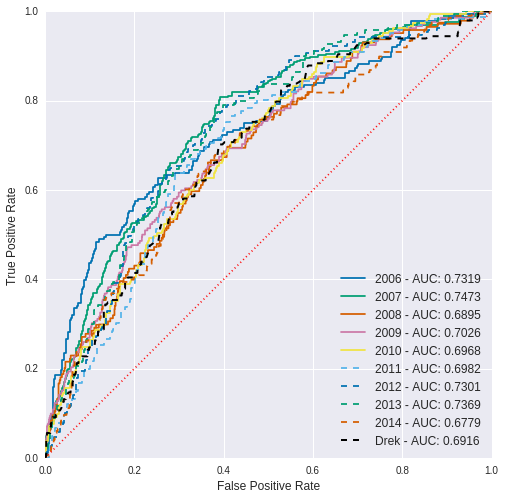

In [23]:
metrics = calc_metrics(model_df, predictors, fits, 
                       metrics=['roc_curve', 'recall_score', 'roc_auc_score'])

plt.figure(figsize=(8,8))
plot_roc(metrics['roc_curve'], drek_df, metrics['roc_auc_score'])